In [ ]:
# Memasang Google Drive sebagai penyimpanan
%cd ..
from google.colab import drive
drive.mount('/content/gdrive')

!ln -s /content/gdrive/My\ Drive/ /mydrive
%cd /mydrive/yolov4

/
Mounted at /content/gdrive
/content/gdrive/My Drive/yolov4


In [ ]:
# Import Dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode, b64encode
import html
import time
import PIL
import io
import cv2
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Kloning Darknet
!git clone https://github.com/AlexeyAB/darknet

fatal: destination path 'darknet' already exists and is not an empty directory.


In [ ]:
# Membangun Darknet 
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
!sed -i 's/LIBSO=0/LIBSO=1/' Makefile
!make

/content/gdrive/My Drive/yolov4/darknet
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -DCUDNN_HALF -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -DCUDNN_HALF -fPIC -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:946:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1147:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
             if (iteratio

In [ ]:
# Import fungsi Darknet untuk melakukan proses deteksi
from darknet import *


# ========================= YOLOv4 - Tiny =========================
# Copy code dibawah ini dan masukkan ke bagian arsitektur jaringan
# network, class_names, class_colors = load_network("cfg/yolov3-tiny.cfg", "data/obj.data", "backup/yolov3-tiny_best.weights")


# ============================ YOLOv4 ============================
# Copy code dibawah ini dan masukkan ke bagian arsitektur jaringan
# network, class_names, class_colors = load_network("cfg/yolov4-custom.cfg", "data/obj.data", "backup/yolov4-custom_best.weights")


# ========================= YOLOv4 - Tiny =========================
# Copy code dibawah ini dan masukkan ke bagian arsitektur jaringan
# network, class_names, class_colors = load_network("cfg/yolov4-tiny-custom.cfg", "data/obj.data", "backup-tiny/yolov4-tiny-custom_best.weights")


# Memuat arsitektur jaringan YOLOv4 atau YOLOv4 Tiny
network, class_names, class_colors = load_network("cfg/yolov4-custom.cfg", "data/obj.data", "backup/yolov4-custom_best.weights")
width = network_width(network)
height = network_height(network)


# Menggunakan Darknet Helper untuk deteksi foto
def darknet_helper(img, width, height):
  darknet_image = make_image(width, height, 3)
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img_resized = cv2.resize(img_rgb, (width, height), interpolation=cv2.INTER_LINEAR)


  # Mendapatkan ratio gambar untuk mengkonversi bounding box ke ukuran yang sesuai
  img_height, img_width, _ = img.shape
  width_ratio = img_width/width
  height_ratio = img_height/height


  # Menjalankan model gambar pada Darknet untuk mendapatkan deteksi
  copy_image_from_bytes(darknet_image, img_resized.tobytes())
  detections = detect_image(network, class_names, darknet_image)
  free_image(darknet_image)
  return detections, width_ratio, height_ratio

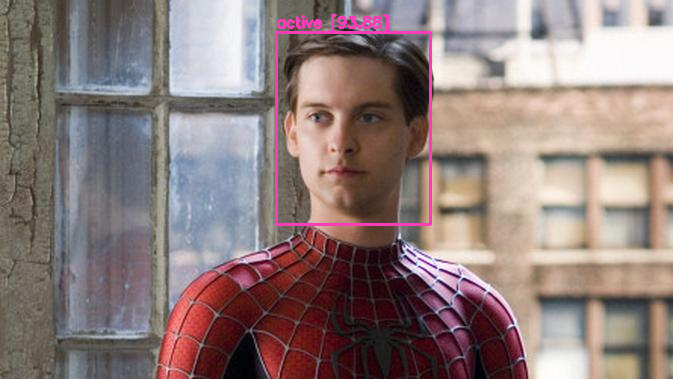

In [ ]:
# Uji deteksi pada gambar
# Ubah Code image untuk mengubah gambar yang akan di deteksi
# image = cv2.imread("data/person-a.jpg") ==> 3 orang dalam 1 gambar terdeteksi active
# image = cv2.imread("data/person-f.jpg") ==> 3 orang dalam 1 gambar terdeteksi fatigue 
# image = cv2.imread("data/spidey.jpg") ==> Foto Spider-Man
# image = cv2.imread("data/obj/active.jpg") ==> Foto Pengemudi Active (172, 173, 176, 177, 214, 327, 332, 437, 507, 646)
# image = cv2.imread("data/obj/fatigue.jpg") ==> Foto Pengemudi Fatigue (1, 8, 56, 61, 74, 76, 331, 359, 393, 403)

image = cv2.imread("data/spidey.jpg")
detections, width_ratio, height_ratio = darknet_helper(image, width, height)

for label, confidence, bbox in detections:
  left, top, right, bottom = bbox2points(bbox)
  left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
  cv2.rectangle(image, (left, top), (right, bottom), class_colors[label], 2)
  cv2.putText(image, "{} [{:.2f}]".format(label, float(confidence)), (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, class_colors[label], 2)
cv2_imshow(image)

In [ ]:
# Mengkonversikan objek pada JavaScript menjadi citra OpenCV
def js_to_image(js_reply):
  # Decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # Mengkonversikan bytes ke bilangan numpy
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # Decode bilangan numpy menjadi citra OpenCV BGR
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img


# Mengubah citra bounding box OpenCV-Rectangle menjadi string byte base64 untuk di-overlay pada streaming video
def bbox_to_bytes(bbox_array):
  # Mengkonversikan bilangan menjadi citra PIL
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # Format bbox menjadi png
  bbox_PIL.save(iobuf, format='png')
  # Format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [ ]:
# Menjalankan deteksi kelelahan melalui foto menggunakan webcam
def take_photo(filename='picture.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture Image';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const streaming = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = streaming;
      await video.play();


      // Mengatur ukuran elemen video
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);
      // Menangkap citra dengan klik tombol 
      await new Promise((resolve) => capture.onclick = resolve);


      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      streaming.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)


  # Mendapatkan foto
  data = eval_js('takePhoto({})'.format(quality))
  
  # Mendapatkan format citra OpenCV
  img = js_to_image(data) 


  # Menggunakan deteksi objek dengan citra webcam
  detections, width_ratio, height_ratio = darknet_helper(img, width, height)


  # Melakukan deteksi dan menambahkan label dan bounding box pada citra webcam
  for label, confidence, bbox in detections:
    left, top, right, bottom = bbox2points(bbox)
    left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
    cv2.rectangle(img, (left, top), (right, bottom), class_colors[label], 2)
    cv2.putText(img, "{} [{:.2f}]".format(label, float(confidence)),
                      (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                      class_colors[label], 2)


  # Menyimpan foto hasil deteksi
  cv2.imwrite(filename, img)

  return filename

<IPython.core.display.Javascript object>

Saved to picture.jpg


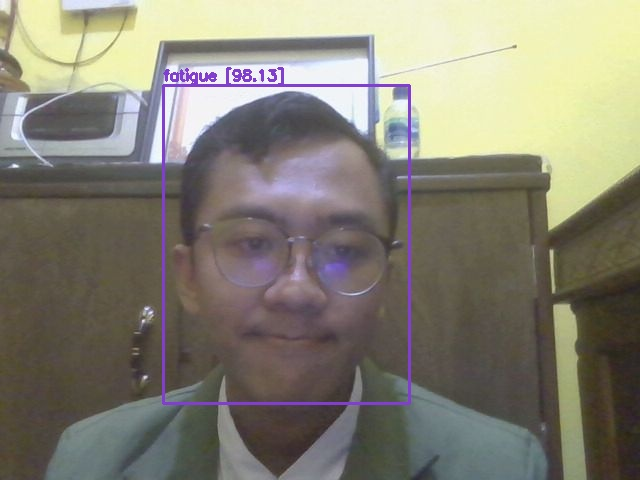

In [ ]:
# Uji deteksi pada foto webcam
try:
  filename = take_photo('picture.jpg')
  print('Saved to {}'.format(filename))
  # Menampilkan foto hasil deteksi
  display(Image(filename))


# Menampilkan error apabila webcam gagal digunakan
except Exception as err:
  print(str(err))

In [ ]:
# Membuat live video streaming sebagai input
def video_streaming():
  js = Javascript('''
    var video;
    var div = null;
    var streaming;
    var getCanvas;
    var imageElement;
    var labelElement;
    
    var pending = null;
    var shutdown = false;
    
    function removeDom() {
       streaming.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       streaming = null;
       imageElement = null;
       getCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pending) {
        var result = "";
        if (!shutdown) {
          getCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = getCanvas.toDataURL('image/jpeg', 0.8)
        }
        var wait = pending;
        pending = null;
        wait(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return streaming;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      streaming = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imageElement = document.createElement('img');
      imageElement.style.position = 'absolute';
      imageElement.style.zIndex = 1;
      imageElement.onclick = () => { shutdown = true; };
      div.appendChild(imageElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: blue; font-weight: bold;">' +
          'Klik pada video streaming untuk mematikan webcam</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = streaming;
      await video.play();

      getCanvas = document.createElement('canvas');
      getCanvas.width = 640; 
      getCanvas.height = 480; 
      window.requestAnimationFrame(onAnimationFrame);
      
      return streaming;
    }
    async function streaming_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      streaming = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imageElement.style.top = videoRect.top + "px";
        imageElement.style.left = videoRect.left + "px";
        imageElement.style.width = videoRect.width + "px";
        imageElement.style.height = videoRect.height + "px";
        imageElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pending = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('streaming_frame("{}", "{}")'.format(label, bbox))
  return data

In [ ]:
# Menjalankan video streaming menggunakan webcam
video_streaming()

# label for video
label_html = 'Shooting...'

# Inisiasi bounding box
bbox = ''
count = 0 
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break


    # Mengkonversikan response Javascript ke citra OpenCV
    frame = js_to_image(js_reply["img"])


    # Membuat overlay transparan untuk bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)


    # Menggunakan deteksi objek pada frame video
    detections, width_ratio, height_ratio = darknet_helper(frame, width, height)

    # Melakukan deteksi dan menambahkan label dan bounding box pada overlay citra
    for label, confidence, bbox in detections:
      left, top, right, bottom = bbox2points(bbox)
      left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
      bbox_array = cv2.rectangle(bbox_array, (left, top), (right, bottom), class_colors[label], 2)
      bbox_array = cv2.putText(bbox_array, "{} [{:.2f}]".format(label, float(confidence)),
                        (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                        class_colors[label], 2)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # Mengkonversikan overlay dari bounding box ke bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # Memperbarui bounding box pada frame berikutnya
    bbox = bbox_bytes

<IPython.core.display.Javascript object>